<a href="https://colab.research.google.com/github/rohitr02/MNIST-Handwritten-Digit-Classification-Analysis/blob/main/digit%20classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First, import some useful packages and set everything up.

In [ ]:
import copy
import csv
import matplotlib 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas
import random
import seaborn

from collections import Counter

def set_seed(seed):  # For reproducibility, fix random seeds.
  random.seed(seed)
  np.random.seed(seed)

set_seed(42)

# Data

Download the MNIST data from the [course Kaggle page](https://www.kaggle.com/c/rutgers-cs461-hw2-fall-2021). We will assume that we have the directory `data/mnist/` in our Google Drive account. Let's load the data and stare at it.  

In [ ]:
# Load the Drive helper and mount. You will have to authorize this operation. 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
datadir = '/content/drive/My Drive/data/MNIST/'

class MNISTDataset:

  def __init__(self, split):
    assert split in ['train', 'train_small', 'val', 'test']
    self.inputs = np.load('{:s}inputs_{:s}.npy'.format(datadir, split))
    self.labels = None
    if split != 'test':
      self.labels, self.label_count = self.get_labels('{:s}labels_{:s}.npy'.format(datadir, split))
      assert self.labels.shape[0] == self.inputs.shape[0]
    self.split = split

  def get_labels(self, filepath):
    label_matrix = np.load(filepath)  # (num_examples, num_labels)
    labels = np.zeros((len(label_matrix), 1)).astype(int)  # (num_examples, 1)
    label_count = Counter()
    for i in range(len(label_matrix)):
      label= np.nonzero(label_matrix[i])[0][0]
      labels[i] = label
      label_count[label] += 1

    return labels, label_count

  def num_examples(self):
    return self.inputs.shape[0]

  def dim(self):
    return self.inputs.shape[1]

  def generate_batch(self, batch_size):
    inds = list(range(self.num_examples()))  
    if self.split == 'train':  # If train, shuffle example indices before generating
      random.shuffle(inds)    
    for i in range(0, len(inds), batch_size):
        inds_batch = inds[i: i + batch_size]
        X = self.inputs[inds_batch, :]
        y = self.labels[inds_batch, :] if self.labels is not None else None
        yield X, y

dataset_train = MNISTDataset('train')
dataset_val = MNISTDataset('val')
dataset_test = MNISTDataset('test')

print('Number of examples (train/val/test): {:d}/{:d}/{:d}'.format(dataset_train.num_examples(), dataset_val.num_examples(), dataset_test.num_examples()))
print('Original number of features (image represented as a vector): {:d}'.format(dataset_train.dim()))
print('First training input looks like this...', dataset_train.inputs[0, 160:200])
print('Label: ', dataset_train.labels[0, 0])

Number of examples (train/val/test): 20000/10000/10000
Original number of features (image represented as a vector): 784
First training input looks like this... [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  6 95 95 95 95
 95 95 95 95 95 31 39  0  0  0  0  0  0  0  0  0]
Label:  5


Note that we don't have labels for the test portion. We can do a better job of visualizing the inputs.

In [ ]:
def visualize_image(image_raw):
  image = image_raw.reshape(28, 28)  # Reshape a vector into a square
  fig = matplotlib.pyplot.figure()
  ax = fig.add_subplot(1, 1, 1)
  imgplot = ax.imshow(image, cmap=matplotlib.cm.Greys)
  imgplot.set_interpolation("nearest")
  ax.xaxis.set_ticks_position("top")
  ax.yaxis.set_ticks_position("left")
  matplotlib.pyplot.axis("off")
  matplotlib.pyplot.show()

First training input


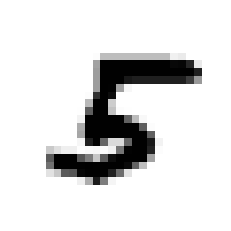

Label:  5


In [ ]:
print('First training input')
visualize_image(dataset_train.inputs[0])
print('Label: ', dataset_train.labels[0, 0])

The dataset is balanced so that we have an equal amount of supervision for each class. This is a luxury: in the wild we will need to deal with datasets with possibly very unbalanced datasets.

In [ ]:
for digit in range(10):
  print('Digit {:1d} has {:3d} training examples'.format(digit, dataset_train.label_count[digit]))

Digit 0 has 2000 training examples
Digit 1 has 2000 training examples
Digit 2 has 2000 training examples
Digit 3 has 2000 training examples
Digit 4 has 2000 training examples
Digit 5 has 2000 training examples
Digit 6 has 2000 training examples
Digit 7 has 2000 training examples
Digit 8 has 2000 training examples
Digit 9 has 2000 training examples


## Feature Normalization

Raw pixel values have high variance and are not mean-centered. To make learning more effective, we'll preprocess the data and normalize each feature (i.e., each pixel) so that each has mean 0 and variance 1 ("$z$-scoring"), similar to what we did in the regression assignment.

In [ ]:
def normalize_features(X, mu=None, sigma=None):
  if mu is None or sigma is None: 
    mu = X.mean(0)
    sigma = X.std(0)
    sigma[sigma < 0.0001] = 1  # Avoid division by zero in case of degenerate features.

  # Normalize features and also add a bias feature.
  X_new = np.concatenate([np.ones((X.shape[0], 1)), (X - mu) / sigma], 1)

  return X_new, mu, sigma

First training input after normalization (not including the bias dimension)


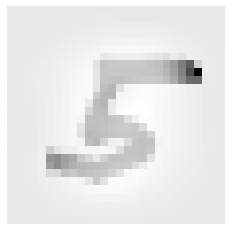

In [ ]:
print('First training input after normalization (not including the bias dimension)')
visualize_image(normalize_features(dataset_train.inputs)[0][0, 1:])

# Softmax 

Define a row-wise softmax that turns any rows of label scores (aka. "logits") into probability distributions over labels, with a numerical stability trick.

In [ ]:
def softmax(scores):  # (num_examples, num_labels)
  nonnegs = np.exp(scores - np.amax(scores, axis=1)[:, np.newaxis])  # Mitigate numerical overflow by subtracting max 
  return nonnegs / np.sum(nonnegs, axis=1)[:, np.newaxis]

In [ ]:
u = np.array([[-1, 2, 0]])
print(u[0], '=>', softmax(u)[0])

[-1  2  0] => [0.04201007 0.84379473 0.1141952 ]


Also, define a row-wise logsumexp that computes the log of the sum of the elements of each row, with a numerical stability trick.

In [ ]:
def logsumexp(scores):  # (num_examples, num_labels)
  rowwise_max = np.amax(scores, axis=1)[:, np.newaxis] 
  return rowwise_max + np.log(np.sum(np.exp(scores - rowwise_max), axis=1)[:, np.newaxis])

In [ ]:
v = np.array([[-1, -2, 3]])
print(logsumexp(v)[0, 0])
print(np.log(np.exp(v).sum()))

print()
w = np.array([[999, 997, 990]])
print(logsumexp(w)[0, 0])
print(np.log(np.exp(w).sum()))  # Without the numerical stability trick, we will encounter an overflow here. 

3.0247448901388228
3.0247448901388228

999.1270367041305
inf


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  


# Model

Our model is a simple linear classifier that treats each image as a single vector. The feature normalization above introduces a bias dimension, so the model does have a bias parameter. Thus the model parameter is a single matrix $W \in \mathbb{R}^{d \times L}$ where $d$ is the dimension of the input (including the bias dimension) and $L$ is the number of labels (here, 10). The $l$-th column $w_l$ of $W$ computes the score of the given input $x \in \mathbb{R}^d$ for the $l$-th label as $w_l^\top x \in \mathbb{R}$. The model has two key functions:

- `forward`: Given $N$ images in a minibatch, it computes scores/logits for all $L=10$ labels, which you can represent as an $N \times L$ matrix. This is all you need to make inference (you just pick argmax), but if it's additionally given gold labels it will also compute the *sum* of per-example negative log probabilities, plus a regularization term, 
$$
- \sum_{i=1}^N \log \frac{\exp(w_{y_i}^\top x_i)}{\sum_{l=1}^L \exp(w_l^\top x_i)} + \lambda \sum_{l=1}^L \sum_{j=2}^d W_{j,l}^2
$$
($\lambda \geq 0$ is a hyperparameter that decides the strength of regularization, note that we don't regularize the bias parameters). This is used for monitoring purposes later. More importantly, it will call the next function to calculate gradients.

- `accumulate_gradients`: Given $N$ images and gold labels, it computes the gradient of the *average* of per-example negative log probabilities, plus the regularization term, 
$$ 
\hat{J}(W) = - \frac{1}{N} \sum_{i=1}^N \log \frac{\exp(w_{y_i}^\top x_i)}{\sum_{l=1}^L \exp(w_l^\top x_i)} + \lambda \sum_{l=1}^L \sum_{j=2}^d W_{j,l}^2
$$
with respect to $W$ evaluated at the *current* value of $W$, then accumulates $\nabla \hat{J}(W) \in \mathbb{R}^{d \times L}$ for gradient-based optimization.

In [ ]:
class LinearClassifier:
    
  def __init__(self, inputs_train, num_labels, init_range=0.0):
    new_features, self.mu, self.sigma = normalize_features(inputs_train)  # Get means and standard devations
    self.dim = new_features.shape[1]

    # Initialize parameters. 
    self.W = np.random.uniform(-init_range, init_range, (self.dim, num_labels))

    # Initialize the gradient.
    self.W_grad = np.zeros((self.dim, num_labels))
                      
  def forward(self, X_raw, y=None, regularization_weight=0.):
    X = normalize_features(X_raw, self.mu, self.sigma)[0]
    scores = np.matmul(X, self.W)  # (batch_size, num_labels)       
    loss_sum = None
    if y is not None:  # We're given gold labels, we're training.

      # TODO: Compute the negative log probabilities here using logsumexp. The NumPy function take_along_axis will also be useful.    # (batch_size,)
      indices = np.matmul(np.arange(len(X)).reshape(len(X), 1), np.ones((1, len(self.W[0])), dtype=int))
      negative_log_probs = np.take_along_axis(logsumexp(scores), indices, axis=0) - scores

      squared_norm_W = np.linalg.norm(self.W[1:, :], 'fro') ** 2  # Don't regularize bias parameters
      loss_sum = np.sum(negative_log_probs) + regularization_weight * squared_norm_W
      self.accumulate_gradients(X, y, scores, regularization_weight)

    return loss_sum, scores
  
  def accumulate_gradients(self, X, y, scores, regularization_weight):
    batch_size, num_labels = scores.shape
    probs = softmax(scores)  

    # TODO: Compute the gradient of the average negative log probability wrt W
    gold_lbl = np.zeros(scores.shape)
    gold_lbl[np.arange(batch_size), np.transpose(y)] = 1
    loss_grad = 1/batch_size * (np.matmul(np.transpose(X), probs - gold_lbl)) # (dim, num_labels)

    # TODO: Compute the gradient of the regularization term (again, remember that bias parameters are not regularized).
    squared_norm_grad = 2 * self.W
    squared_norm_grad[0] = 0
    self.W_grad += loss_grad + regularization_weight * squared_norm_grad
      
  def predict(self, X_raw):
      _, scores = self.forward(X_raw)
      preds = np.argmax(scores, axis=1)[:, np.newaxis]  # (batch_size, 1)
      return preds

  def zero_grad(self):
    self.W_grad.fill(0.)
      
  def num_parameters(self):
    return self.W.size 

## Gradient Check

One useful way to ensure that your gradient computation is absolutely correct is to do what's called the **gradient check**. Recall that *by definition* the derivative of a function $f$ of some scalar variable $x \in \mathbb{R}$ evaluated at $x = a$ is:

$$
f'(a) = \lim_{\epsilon \rightarrow 0} \frac{f(x + \epsilon) - f(x)}{\epsilon}
$$

Thus we can set some small $\epsilon > 0$ and check if this is indeed the case for our gradients. Remember, in our case the function of interest is $\hat{J}(W)$ above, defined on a single batch of labeled examples. We are calculating the gradient of that function with respect to model parameters $W$. Even though this is matrix-valued, a gradient is simply an array of partial derivatives so we can check each derivative individually. 

In [ ]:
import unittest

class TestGradient(unittest.TestCase):

  def setUp(self):
    set_seed(42)
    dim = 100
    num_labels = 7
    num_examples = 10
    self.model = LinearClassifier(np.random.randn(num_examples, dim), num_labels, init_range=0.01)
    self.X = np.random.randn(num_examples, dim)
    self.y = np.random.randint(num_labels, size=(num_examples, 1))
    self.epsilon = 1e-4
    self.regularization_weight = 0.01
    self.loss_avg = self.model.forward(self.X, self.y, self.regularization_weight)[0] / num_examples
    self.model.zero_grad()
      
  def test_gradient_W(self):
    for i in range(self.model.W.shape[0]):
      for j in range(self.model.W.shape[1]): 
        self.model.W[i, j] += self.epsilon
        loss_avg_perturbed = self.model.forward(self.X, self.y, self.regularization_weight)[0] / self.X.shape[0]
        partial_derivative_i_j = self.model.W_grad[i, j]
        truth = (loss_avg_perturbed - self.loss_avg) / self.epsilon
        error = abs(partial_derivative_i_j - truth)
        self.assertLess(error, 1e-0)
        self.model.W[i, j] -= self.epsilon
        self.model.zero_grad()
            
unittest.main(TestGradient(), argv=[''], verbosity=2, exit=False)

test_gradient_W (__main__.TestGradient) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.161s

OK


# Training

We will use stochastic gradient descent (SGD) to optimize the average cross-entropy loss above. Define a simple SGD optimizer class, which updates parameters of the associated model.

In [ ]:
class SGDOptimizer:
    
  def __init__(self, model, learning_rate):
    self.model = model
    self.lr = learning_rate
      
  def step(self):
    self.model.W -= self.lr * self.model.W_grad
      
  def zero_grad(self):
    self.model.zero_grad()
      
  def modify_lr(self, learning_rate):
    self.lr = learning_rate    

In [ ]:
def evaluate_accuracy(model, dataset_eval, batch_size_eval=64):
  num_correct = 0
  for X, y in dataset_eval.generate_batch(batch_size_eval):
    num_correct += np.sum(model.predict(X) == y)
  return num_correct / dataset_eval.num_examples() * 100.

In [ ]:
def train(dataset_train, dataset_val, learning_rate=0.1, init_range=0., batch_size=16, regularization_weight=0., max_num_epochs=10, seed=42, loss_improvement=0.01, decay=2., tolerance=5, verbose=False):
  set_seed(seed)  
  model = LinearClassifier(dataset_train.inputs, 10, init_range=init_range)  
  optimizer = SGDOptimizer(model, learning_rate)
  
  best_acc_val = float('-inf')
  best_W = None
  num_continuous_fails = 0
  loss_avg_before = None
  
  if verbose:
    print('Num parameters {:d}'.format(model.num_parameters()))
    print('Batch size {:d}, learning rate {:.5f}, regularization_weight {:.5f}'.format(batch_size, learning_rate, regularization_weight))
      
  for epoch in range(max_num_epochs):
    loss_total = 0.
    num_correct = 0    

    for X, y in dataset_train.generate_batch(batch_size):  # Shuffled in each epoch
      loss_sum, scores = model.forward(X, y, regularization_weight)
      loss_total += loss_sum
      preds = np.argmax(scores, axis=1)[:, np.newaxis]
      num_correct += np.sum(preds == y)

      optimizer.step()
      optimizer.zero_grad()

    loss_avg = loss_total / dataset_train.num_examples()
    acc_train = num_correct / dataset_train.num_examples() * 100. 
    acc_val = evaluate_accuracy(model, dataset_val)
  
    if acc_val > best_acc_val:
      num_continuous_fails = 0
      best_acc_val = acc_val
      best_W = copy.deepcopy(model.W)
    else:
      num_continuous_fails += 1
      if num_continuous_fails > tolerance:
        if verbose: 
            print('Early stopping')
        break
    
    if loss_avg_before is not None:
      if loss_avg_before - loss_avg < loss_improvement:  # Training loss has not improved sufficiently, decay the learning rate
        optimizer.modify_lr(optimizer.lr / decay)
        if verbose and decay != 1.0:
          print('Decaying learning rate to {:.5f}'.format(optimizer.lr))
    loss_avg_before = loss_avg 

    if verbose:
      print('End of epoch {:3d}:\t loss avg {:10.4f}\t acc train {:10.2f}\t acc val {:10.2f}'.format(
          epoch + 1, loss_avg, acc_train, acc_val)) 

  model.W = best_W
  if verbose:
    print('Best acc val: {:10.2f}'.format(best_acc_val))

  return model, best_acc_val, loss_avg, acc_train

In [ ]:
model, acc_val, loss_avg, acc_train = train(dataset_train, dataset_val, learning_rate=5., batch_size=24, decay=2, verbose=True)

Num parameters 7850
Batch size 24, learning rate 5.00000, regularization_weight 0.00000
End of epoch   1:	 loss avg  3085.8827	 acc train      83.85	 acc val      86.77
Decaying learning rate to 2.50000
End of epoch   2:	 loss avg  4194.0283	 acc train      87.52	 acc val      85.44
End of epoch   3:	 loss avg  4166.1982	 acc train      90.57	 acc val      89.15
End of epoch   4:	 loss avg  3664.9682	 acc train      90.64	 acc val      89.64
End of epoch   5:	 loss avg  3427.0952	 acc train      90.98	 acc val      88.32
End of epoch   6:	 loss avg  3288.2070	 acc train      90.68	 acc val      87.90
End of epoch   7:	 loss avg  3183.8393	 acc train      90.67	 acc val      87.82
Decaying learning rate to 1.25000
End of epoch   8:	 loss avg  3234.7207	 acc train      90.68	 acc val      86.64
End of epoch   9:	 loss avg  3080.0421	 acc train      92.38	 acc val      89.15
Early stopping
Best acc val:      89.64


# Hyperparameter Tuning

Experiments usually involve heavy hyperparameter tuning. This means you try a few different values of key hyperparameters to find one that works best (on validation data). For stochastic gradient descent, two important hyperparameters are the *batch size* and the *learning rate*. These two interact, so you have to search over their joint space. Typically you change them on a logarithmic scale (e.g., 0.0001, 0.001, 0.01, 0.1 for learning rates, 16, 32, 64, 128, 256 for batch sizes). 

However, to focus on the effect of regularization, we will fix the batch size and learning rate to be some reasonable values and only vary the regularization weight. 

In [ ]:
model_best = None
best_acc_val = float('-inf')
for batch_size in [16]:
  for learning_rate in [0.1]:
    for regularization_weight in [0, 0.0001, 0.001, 0.0015, 0.01, 1.0, 10.0]:
      model, acc_val, loss_avg, acc_train = train(dataset_train, dataset_val, learning_rate=learning_rate, batch_size=batch_size, regularization_weight=regularization_weight, max_num_epochs=60)
      print('Lambda {:10.4f}\t loss {:10.4f}\t acc train {:2.2f}\t acc val {:2.2f}'.format(regularization_weight, loss_avg, acc_train, acc_val))
      if acc_val > best_acc_val:
        best_acc_val = acc_val
        model_best = copy.deepcopy(model)

print(best_acc_val)

Lambda     0.0000	 loss   118.8762	 acc train 93.91	 acc val 91.14
Lambda     0.0001	 loss   114.2798	 acc train 94.56	 acc val 91.16
Lambda     0.0010	 loss    93.1803	 acc train 94.62	 acc val 91.71
Lambda     0.0015	 loss    87.7386	 acc train 94.23	 acc val 91.84
Lambda     0.0100	 loss    65.3798	 acc train 92.53	 acc val 91.69
Lambda     1.0000	 loss    27.6308	 acc train 84.45	 acc val 84.57
Lambda    10.0000	 loss    23.2356	 acc train 77.46	 acc val 76.93
91.84


## Question

**What is the impact of regularization on training loss/accuracy and validation accuracy?**

As the regularization value of lambda increases from something extremely small, the loss decreases, training accuracy increases, and validation accuracy increases. However, there exists some point where increasing the regularization value of lambda actually hurts the training accuracy and the validation accuracy so this means we cannot just increase it to be anything we want -- there is an optimal value.



# Qualitative Analysis

## Weight Visualization

Since the model parameters are $w_l \in \mathbb{R}^d$ for $l = 1 \ldots 10$ where the $(i+1)$th dimension corresponds to how much the $i$-th pixel value (shifted due to the bias dimension) implies the $l$-th label (i.e., digit $l-1$), we can directly visualize the parameters.

In [ ]:
def visualize_model(model):
  fig = plt.figure(figsize=(20,10))
  for label in range(10):
    plt.subplot(2, 5, label + 1)
    plt.imshow(model.W[1:, label].reshape(28, 28))
    plt.title('Label {:d}'.format(label))
    plt.colorbar()
  plt.show()

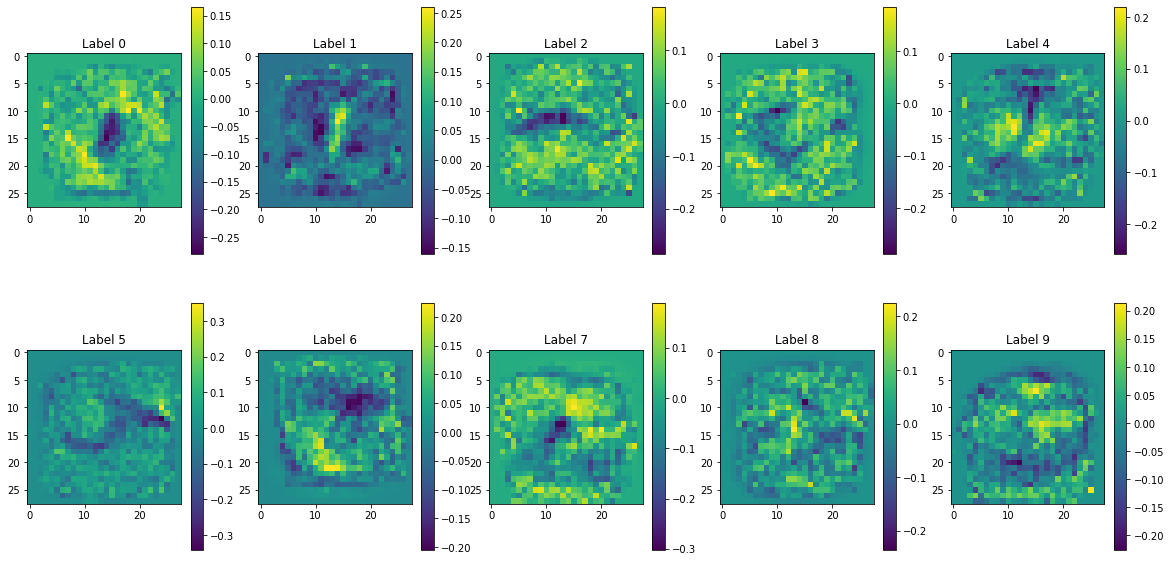

In [ ]:
visualize_model(model_best)

### Question

**What do you observe about the visualized weights for each class label?**

I can observe the vague outlines of certain numbers for certain labels but it is quite blurry.

## Confusion Matrix


Because we only have 10 labels we can easily visualize the prediction behavior of the model through a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). 

In [ ]:
def build_confusion_matrix(model, dataset_val, batch_size_eval=64):
  confusion_matrix = [[0 for _ in range(10)] for _ in range(10)]
  for X, y in dataset_val.generate_batch(batch_size_eval):
    preds = model.predict(X)
    for i in range(X.shape[0]):
      confusion_matrix[y[i, 0]][preds[i][0]] += 1

  for label1 in range(10):
    num_label1_total = sum(confusion_matrix[label1])
    for label2 in range(10):
      confusion_matrix[label1][label2] /= num_label1_total / 100

  return confusion_matrix

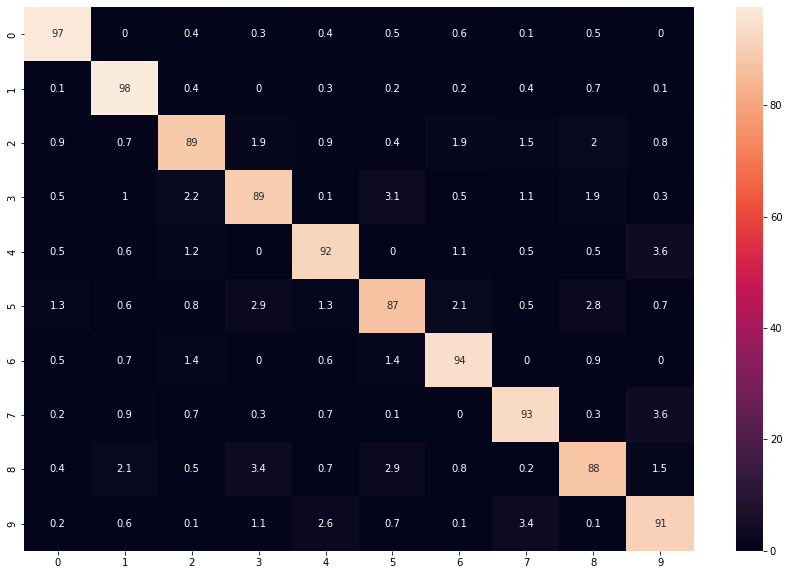

In [ ]:
df = pandas.DataFrame(build_confusion_matrix(model_best, dataset_val), 
                      index=[str(digit) for digit in range(10)], columns=[str(digit) for digit in range(10)])
plt.figure(figsize = (15,10))
seaborn.heatmap(df, annot=True)

### Question

** What do you observe in the confusion matrix? **

It is mostly predicting the values accurately given by the fact that the diagonals are much lighter than the other boxes. The diagonals being highlighted is good here because it means a picture with the digit i is being labelled as i more accurately than being labelled as any other digit.

# Small Data Regime

To study the effect of the amount of supervision, we will train the model on a small subset of the training dataset with 30 examples total (3 examples per digit). 

In [ ]:
dataset_train_small = MNISTDataset('train_small')

print(dataset_train_small.num_examples())
for digit in range(10):
  print('Digit {:1d} now has only {:1d} training examples'.format(digit, dataset_train_small.label_count[digit]))

30
Digit 0 now has only 3 training examples
Digit 1 now has only 3 training examples
Digit 2 now has only 3 training examples
Digit 3 now has only 3 training examples
Digit 4 now has only 3 training examples
Digit 5 now has only 3 training examples
Digit 6 now has only 3 training examples
Digit 7 now has only 3 training examples
Digit 8 now has only 3 training examples
Digit 9 now has only 3 training examples


Let's again do a model selection over the choice of $\lambda$ (regularization strength), with batch size/learning rate fixed to some reasonable values. 

In [ ]:
model_best_small = None
best_acc_val_small = float('-inf')
for batch_size in [8]:
  for learning_rate in [0.1]:
    for regularization_weight in [0, 0.0001, 0.001, 0.01, 1.0, 10.0]:
      model, acc_val, loss_avg, acc_train = train(dataset_train_small, dataset_val, learning_rate=learning_rate, batch_size=batch_size, regularization_weight=regularization_weight, max_num_epochs=60)
      print('Lambda {:10.4f}\t loss {:10.4f}\t acc train {:2.2f}\t acc val {:2.2f}'.format(regularization_weight, loss_avg, acc_train, acc_val))
      if acc_val > best_acc_val_small:
        best_acc_val_small = acc_val
        model_best_small = copy.deepcopy(model)

Lambda     0.0000	 loss    64.4898	 acc train 100.00	 acc val 56.33
Lambda     0.0001	 loss    64.4802	 acc train 100.00	 acc val 56.33
Lambda     0.0010	 loss    64.3932	 acc train 100.00	 acc val 56.33
Lambda     0.0100	 loss    63.5371	 acc train 100.00	 acc val 56.36
Lambda     1.0000	 loss    32.1404	 acc train 100.00	 acc val 57.81
Lambda    10.0000	 loss    23.6567	 acc train 100.00	 acc val 54.52


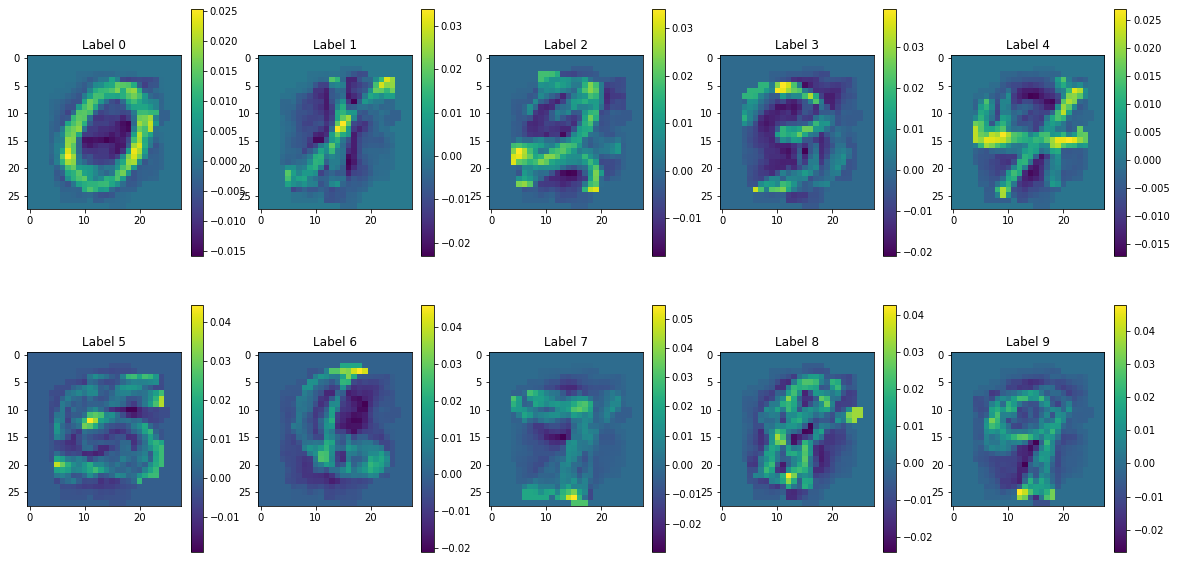

In [ ]:
visualize_model(model_best_small)

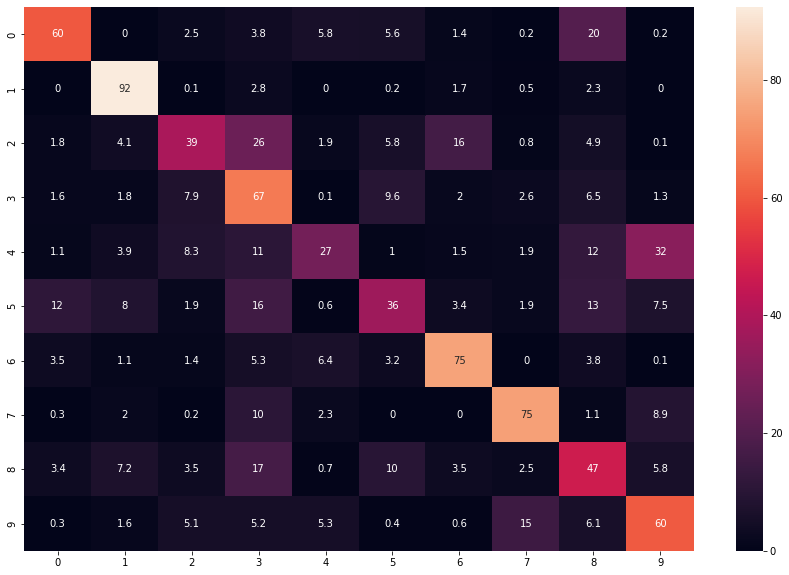

In [ ]:
df = pandas.DataFrame(build_confusion_matrix(model_best_small, dataset_val), 
                      index=[str(digit) for digit in range(10)], columns=[str(digit) for digit in range(10)])
plt.figure(figsize = (15,10))
seaborn.heatmap(df, annot=True)

## Question

What do you observe about the *weight visualization* and *confusion matrix* **compared to the large training data** setting?

The weight visualization is much more clearer when compare to the large training data. However, the confusion matrix is a lot less accurate or clear than when compared to the large training data. We can see this because the values along the diagonal of the confusion matrix are not significantly brighter than the other values -- in other words the digit i is being mispredicted more often than when compared to the large training data.

# Kaggle Submission

To make the assignment more engaging we have a [Kaggle competition](https://www.kaggle.com/c/rutgers-cs461-hw2-fall-2021)! We will make test predictions with the best model we can train on the full training dataset (best in validation accuracy). Don't use more training data (in particular, don't retrain on train+val), but you can go back to the hyperparameter tuning and search other values of

- Batch size
- Learning rate
- Max number of epochs
- Learning rate decay

and others. It's fine to "guess" at this or that value, but it's usually best to be systematic about it and sweep all configurations because we don't know which hyperparameters interact with which (e.g., learning rate interacts strongly with batch size). If you feel ambitious you might even try [different gradient-based optimization methods](https://ruder.io/optimizing-gradient-descent/) like Adagrad or Adam. 


In [ ]:
def create_kaggle_submission(model, dataset_test, netid, batch_size_eval=64):
  preds = []
  for X, _ in dataset_test.generate_batch(batch_size_eval):  # Not shuffled
    preds.extend(model.predict(X)[:, 0].tolist())

  with open('/content/drive/My Drive/cs461hw2_{:s}.csv'.format(netid), 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['id', 'category'])  # Header
    for i, pred in enumerate(preds):
        writer.writerow([i, pred])

In [ ]:
# Use your best model (assumed model_best) with your NetID here.
create_kaggle_submission(model_best, dataset_test, 'rpr79') 

This creates a file in your Google Drive `cs461hw2_mynetid.csv`. You can upload it to Kaggle and check how you're doing compared to others on the public leaderboard (50% of the test data). The final evaluation is shown on the private leaderboard (the other 50% of the test data), which is not revealed until after the competition is over.

## Question

Report the result of your **best model** 
- Training accuracy : 94.23
- Validation accuracy : 91.84
- Test accuracy on public leaderboard (from Kaggle submission) : 91.520